In [43]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa

In [44]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [45]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [46]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [47]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [48]:
# mport train
df_train = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/test_split_Depression_AVEC2017.csv')
df_test_full = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/full_test_split.csv')
df_dev = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/dev_split_Depression_AVEC2017.csv')

In [49]:
df_test['Participant_ID'] = df_test['participant_ID']
df_test.drop('participant_ID', axis=1, inplace=True)

In [50]:
# Check if all data seems ok
print(df_train.shape[0], df_test_full.shape[0], df_dev.shape[0], df_train.shape[0]+ df_test_full.shape[0]+ df_dev.shape[0])

107 47 35 189


In [51]:
import os
import imageio
import pandas as pd
import numpy as np
import glob

def load_spectrogram(df):
    # Define root path of data
    root_path = 'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data'  # Replace with your root path

    # Add the column for spectrogram if it doesn't exist
    if 'Spectrogram' not in df.columns:
        # Define the shape of the fixed tensor
        tensor_shape = (292, 252, 3)  # Example shape (height, width, channels)

        # Create a fixed tensor of zeros with the desired shape
        fixed_tensor = np.zeros(tensor_shape, dtype=np.uint8)  # Adjust dtype as needed

        # Initialize the 'Spectrogram' column with the fixed tensor
        df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]

    # Handle missing values in 'Participant_ID' column
    df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')

    # Create an empty list to store modified rows
    modified_rows = []
    for index, row in df.iterrows():
            if not pd.isnull(row['Participant_ID']):  # Check if Participant_ID is not NaN
                participant_id = str(int(row['Participant_ID']))
                folder_path = os.path.join(root_path, str(participant_id) + '_P/resized')
                if os.path.isdir(folder_path):
                    # Flag to check if the first spectrogram has been loaded
                    first_loaded = False
                    # Iterate over image files in the folder
                    for image_file in glob.glob(os.path.join(folder_path, '*.jpg')):
                        image_path = os.path.join(folder_path, image_file)
                        if os.path.isfile(image_path):
                            # If it's the first spectrogram, add it to the original row
                            if not first_loaded:
                                image = imageio.imread(image_path)
                                row['Spectrogram'] = image
                                modified_rows.append(row)  # Add the modified row to the list
                                first_loaded = True
                            else:
                                # Create a copy of the original row
                                new_row = row.copy()
                                # Load the new image
                                new_image = imageio.imread(image_path)
                                # Assign the new image to the 'Spectrogram' column of the new row
                                new_row['Spectrogram'] = new_image
                                # Append the new row to the list
                                modified_rows.append(new_row)
                        else:
                            print(f"Image file not found at path {image_path}. Skipping...")
                else:
                    print(f"Folder not found at path {folder_path}. Skipping...")
                    raise Exception
    # Concatenate the original DataFrame with the modified rows
    #modified_df = pd.concat([df] + modified_rows, ignore_index=True)
    modified_df = pd.DataFrame(modified_rows)
    return modified_df
    #return df


In [52]:

df_test = load_spectrogram(df_test)
# Define root path of data


C:\Users\herna\AppData\Local\Temp\ipykernel_30128\1015463473.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\herna\AppData\Local\Temp\ipykernel_30128\1015463473.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  new_image = imageio.imread(image_path)


In [53]:
df_test.shape

(282, 3)

In [54]:
df_test.head()

,Gender,Participant_ID,Spectrogram
0,1,300,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
0,1,300,"[[[0, 0, 0], [0, 0, 0], [0, 0, 2], [1, 1, 3], ..."
0,1,300,"[[[0, 0, 0], [0, 0, 0], [0, 0, 2], [1, 1, 3], ..."
0,1,300,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
0,1,300,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."


In [55]:
df_test.tail(15)

,Gender,Participant_ID,Spectrogram
44,0,470,"[[[1, 0, 0], [4, 3, 1], [1, 0, 4], [1, 0, 7], ..."
44,0,470,"[[[9, 5, 0], [4, 0, 0], [14, 10, 11], [4, 0, 5..."
44,0,470,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [0, 0, 0], ..."
45,1,480,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
45,1,480,"[[[0, 0, 2], [0, 0, 2], [0, 0, 2], [0, 0, 2], ..."
45,1,480,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
45,1,480,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
45,1,480,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
45,1,480,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
46,1,481,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."


In [56]:
df_test_full = load_spectrogram(df_test_full)

C:\Users\herna\AppData\Local\Temp\ipykernel_30128\1015463473.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\herna\AppData\Local\Temp\ipykernel_30128\1015463473.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  new_image = imageio.imread(image_path)


In [57]:
x_test = df_test['Spectrogram']
y_test = df_test_full['PHQ_Binary']

In [58]:
df_train = load_spectrogram(df_train)

C:\Users\herna\AppData\Local\Temp\ipykernel_30128\1015463473.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\herna\AppData\Local\Temp\ipykernel_30128\1015463473.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  new_image = imageio.imread(image_path)


In [59]:
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,307,0,4,0,0,1,0,1,0,2,0,0
2,331,0,8,1,1,1,1,1,1,1,1,1
3,335,1,12,0,1,1,3,2,3,1,1,0
4,346,1,23,0,2,3,3,3,3,3,3,3


In [60]:
df_dev = load_spectrogram(df_dev)

C:\Users\herna\AppData\Local\Temp\ipykernel_30128\1015463473.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\herna\AppData\Local\Temp\ipykernel_30128\1015463473.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  new_image = imageio.imread(image_path)


In [61]:
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,Spectrogram
0,302,0,4,1,1,1,0,1,0,1,0,0,"[[[1, 1, 0], [1, 0, 5], [11, 2, 29], [22, 5, 4..."
0,302,0,4,1,1,1,0,1,0,1,0,0,"[[[1, 1, 1], [0, 0, 7], [9, 3, 31], [16, 8, 49..."
0,302,0,4,1,1,1,0,1,0,1,0,0,"[[[1, 1, 1], [0, 0, 7], [11, 2, 31], [21, 6, 4..."
0,302,0,4,1,1,1,0,1,0,1,0,0,"[[[0, 0, 18], [3, 3, 15], [6, 6, 6], [0, 0, 0]..."
0,302,0,4,1,1,1,0,1,0,1,0,0,"[[[0, 0, 19], [5, 4, 22], [8, 6, 20], [0, 0, 9..."


In [62]:
df_train.iloc[[1]]['Spectrogram'][0].shape

(252, 792, 3)

In [63]:
depressed_count = df_train['PHQ8_Depressed'].sum()
non_depressed_count = len(df_train) - depressed_count

print("Number of depressed instances:", depressed_count)
print("Number of non-depressed instances:", non_depressed_count)

Number of depressed instances: 516
Number of non-depressed instances: 126


In [64]:
df_train[df_train['PHQ8_Depressed'] == 1].count()

Participant_ID        258
PHQ8_Binary           258
PHQ8_Score            258
Gender                258
PHQ8_NoInterest       258
PHQ8_Depressed        258
PHQ8_Sleep            252
PHQ8_Tired            258
PHQ8_Appetite         258
PHQ8_Failure          258
PHQ8_Concentrating    258
PHQ8_Moving           258
Spectrogram           258
dtype: int64

In [65]:
df_train[df_train['PHQ8_Depressed'] == 0].count()

Participant_ID        276
PHQ8_Binary           276
PHQ8_Score            276
Gender                276
PHQ8_NoInterest       276
PHQ8_Depressed        276
PHQ8_Sleep            276
PHQ8_Tired            276
PHQ8_Appetite         276
PHQ8_Failure          276
PHQ8_Concentrating    276
PHQ8_Moving           276
Spectrogram           276
dtype: int64

In [66]:
# Define a custom callback to print the epoch number
class PrintEpochNumber(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']}")

# Assuming df_train and df_dev are your DataFrames and they're already preprocessed
X_train = np.array(df_train['Spectrogram'].tolist())
y_train = df_train['PHQ8_Depressed'].values

X_val = np.array(df_dev['Spectrogram'].tolist())
y_val = df_dev['PHQ8_Depressed'].values

print(X_train.shape, ' ', y_train.shape)
print(X_val.shape, ' ', y_val.shape)


(642, 252, 792, 3)   (642,)
(210, 252, 792, 3)   (210,)


# Joining dataset


In [67]:
df_test_full['PHQ8_Binary'] = df_test_full['PHQ_Binary']

In [68]:
df_test_full.drop('PHQ_Binary', axis=1, inplace=True)

In [69]:
new_df_train = pd.concat([df_test_full, df_dev, df_train], axis=0)

In [70]:
print(new_df_train.shape)
print(df_dev.shape)
print(df_test_full.shape)
print(df_train.shape)

(1134, 14)
(210, 13)
(282, 5)
(642, 13)


In [71]:
print(new_df_train.columns)
print(df_dev.columns)
print(df_test_full.columns)
print(df_train.columns)

Index(['Participant_ID', 'PHQ_Score', 'Gender', 'Spectrogram', 'PHQ8_Binary',
       'PHQ8_Score', 'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep',
       'PHQ8_Tired', 'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating',
       'PHQ8_Moving'],
      dtype='object')
Index(['Participant_ID', 'PHQ8_Binary', 'PHQ8_Score', 'Gender',
       'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
       'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving',
       'Spectrogram'],
      dtype='object')
Index(['Participant_ID', 'PHQ_Score', 'Gender', 'Spectrogram', 'PHQ8_Binary'], dtype='object')
Index(['Participant_ID', 'PHQ8_Binary', 'PHQ8_Score', 'Gender',
       'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
       'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving',
       'Spectrogram'],
      dtype='object')


In [72]:
new_df_train.head()

,Participant_ID,PHQ_Score,Gender,Spectrogram,PHQ8_Binary,PHQ8_Score,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,300,2.0,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,300,2.0,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 2], [1, 1, 3], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,300,2.0,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 2], [1, 1, 3], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,300,2.0,1,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,300,2.0,1,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
new_df_train = new_df_train[['Participant_ID', 'PHQ8_Binary', 'Spectrogram']]

In [74]:
new_df_train.shape

(1134, 3)

In [75]:
(new_df_train[new_df_train['PHQ8_Binary'] == 1].count())["PHQ8_Binary"]

336

In [76]:
new_df_train[new_df_train['PHQ8_Binary'] == 0].count()['PHQ8_Binary']

798

In [77]:
X_train = np.array(new_df_train['Spectrogram'].tolist())
y_train = new_df_train['PHQ8_Binary'].values

# K-folds

In [78]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

mean_acc_per_fold = []
mean_loss_per_fold = []
kfold_list = []
mean_precision_per_fold = []

In [ ]:
for fold_it in range(3,11):
  # Vars to get means
  acc_per_fold = []
  loss_per_fold = []
  precision_per_fold = []

  # Hiperparameters
  batch_size = 1
  no_epochs = 100
  verbosity = 2 #1
  # Define the K-fold Cross Validator
  num_folds = fold_it
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # K-fold Cross Validation model evaluation for prints
  fold_no = 1

  for train, test in kfold.split(X_train, y_train):
    # Define the model architecture
    model = Sequential()
    # Convolutional block 1
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    # Convolutional block 2
    model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    # Convolutional block 3
    model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    # Convolutional block 4
    model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid') )
    
    # Compile the model
    model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.SpecificityAtSensitivity(sensitivity=1)])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=3,
                                                min_delta=0.0001)

    # Fit data to model
    history = model.fit(X_train[train], y_train[train],
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[callback])

    # Generate generalization metrics
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]}: {scores[2]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    precision_per_fold.append(scores[2])
    
    if(scores[1]*100 > 60):
      folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/{num_folds}-fold_18_04_2024/'
      if not os.path.exists(folder_path):
          os.makedirs(folder_path)
      
      subfolder_path = folder_path + f'{fold_no}-{scores[1]*100}/'
      if not os.path.exists(subfolder_path):
          os.makedirs(subfolder_path)

      model.save(subfolder_path + f'fold-{fold_no}.h5')  # Replace with your actual path
      df_to_save = new_df_train.iloc[train].copy()
      df_to_save.drop('Spectrogram',axis=1, inplace=True)
      df_to_save.to_csv(subfolder_path + f'train-data-fold-{fold_no}.csv', index=False)
    # Increase fold number
    fold_no = fold_no + 1

  # Get means
  mean_acc = sum(acc_per_fold) / len(acc_per_fold)
  mean_loss = sum(loss_per_fold) / len(loss_per_fold)
  mean_precision = sum(precision_per_fold) / len(precision_per_fold)
  # Append to list to graph
  mean_acc_per_fold.append(mean_acc)
  mean_loss_per_fold.append(mean_loss)
  mean_precision_per_fold.append(mean_precision)
  kfold_list.append(num_folds)

  with open(folder_path+'score.txt', 'w') as file:
        # Write 'hello' to the file
        file.write(f' accuracy: {mean_acc}. loss: {mean_loss}. precision: {mean_precision}')
  # Plot training accuracy per fold


SyntaxError: invalid syntax (3706456642.py, line 47)

In [39]:
scores

[0.00403622817248106, 1.0, 1.0]

In [38]:
import os
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Flatten, Dense

# Define your data: X_train, y_train, etc.

# Variables to store metrics for each fold

# Hiperparameters
batch_size = 1
no_epochs = 100
verbosity = 1#2  # 1

for fold_it in [5, 10]:
    # Vars to get means
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    mean_specificity_per_fold = []
    mean_f1_per_fold = []
    mean_acc_per_fold = []
    mean_loss_per_fold = []
    mean_recall_per_fold =[]
    mean_precision_per_fold = []
    kfold_list = []


    # Define the K-fold Cross Validator
    num_folds = fold_it
    kfold = KFold(n_splits=num_folds, shuffle=False)

    # K-fold Cross Validation model evaluation for prints
    fold_no = 1

    for train, test in kfold.split(X_train, y_train):
        # Define the model architecture
        model = Sequential()
        # Convolutional block 1
        model.add(BatchNormalization())
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        # Convolutional block 2
        model.add(BatchNormalization())
        model.add(Conv2D(8, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        # Convolutional block 3
        model.add(BatchNormalization())
        model.add(Conv2D(4, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        # Convolutional block 4
        model.add(BatchNormalization())
        model.add(Conv2D(4, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))

        model.add(Flatten())

        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision()])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=3,
                                                    min_delta=0.0001)

        # Fit data to model
        history = model.fit(X_train[train], y_train[train],
                            batch_size=batch_size,
                            epochs=no_epochs,
                            verbose=verbosity,
                            callbacks=[callback])

        # Evaluate the model on test data
        scores = model.evaluate(X_train[test], y_train[test], verbose=0)

        # Generate generalization metrics
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')

        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        precision_per_fold.append(scores[2])

        # Increase fold number
        fold_no += 1

        # Get means for each fold
        mean_acc = sum(acc_per_fold) / len(acc_per_fold)
        mean_loss = sum(loss_per_fold) / len(loss_per_fold)
        mean_precision = sum(precision_per_fold) / len(precision_per_fold)

        # Append means to list for later use
        mean_acc_per_fold.append(mean_acc)
        mean_loss_per_fold.append(mean_loss)
        mean_precision_per_fold.append(mean_precision)
        kfold_list.append(num_folds)

        # Calculate specificity and F1 Score for the current fold
        all_y_pred = []
        all_y_true = []
        #for train, test in kfold.split(X_train, y_train):
        y_pred = model.predict(X_train[test])
        #all_y_pred.extend(y_pred.round())
        #all_y_true.extend(y_train[test])

        tn, fp, fn, tp = confusion_matrix(all_y_true, all_y_pred).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * recall) / (precision + recall)

        # Append specificity and F1 Score to list for later calculation of overall mean
        mean_specificity_per_fold.append(specificity)
        mean_recall_per_fold.append(recall) 
        mean_f1_per_fold.append(f1)
    

    # Calculate mean values across all folds
    mean_specificity_overall = sum(mean_specificity_per_fold) / len(mean_specificity_per_fold)
    mean_f1_overall = sum(mean_f1_per_fold) / len(mean_f1_per_fold)
    mean_acc_overall = sum(mean_acc_per_fold) / len(mean_acc_per_fold)
    mean_loss_overall = sum(mean_loss_per_fold) / len(mean_loss_per_fold)
    mean_precision_overall = sum(mean_precision_per_fold) / len(mean_precision_per_fold)
    mean_recall_overall = sum(mean_recall_per_fold) / len(mean_recall_per_fold)

    folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/{num_folds}-fold_11_04_2024/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # Write mean values to the scores.txt file
    with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
        file.write(f'Mean Specificity: {mean_specificity_overall}\n')
        file.write(f'Mean Recall: {mean_recall_overall}\n')
        file.write(f'Mean F1 Score: {mean_f1_overall}\n')
        file.write(f'Mean Accuracy: {mean_acc_overall}\n')
        file.write(f'Mean Loss: {mean_loss_overall}\n')
        file.write(f'Mean Precision: {mean_precision_overall}\n')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
907/907 [==============================] - 35s 38ms/step - loss: 2.4311 - accuracy: 0.8611 - precision_1: 0.7844
Epoch 2/100
907/907 [==============================] - 31s 34ms/step - loss: 0.0043 - accuracy: 1.0000 - precision_1: 1.0000
Epoch 3/100
907/907 [==============================] - 30s 33ms/step - loss: 8.5470e-04 - accuracy: 1.0000 - precision_1: 1.0000
Epoch 4/100
907/907 [==============================] - 31s 34ms/step - loss: 4.2927e-04 - accuracy: 1.0000 - precision_1: 1.0000
Epoch 5/100
907/907 [==============================] - 30s 33ms/step - loss: 2.5120e-04 - accuracy: 1.0000 - precision_1: 1.0000
Epoch 6/100
907/907 [==============================] - 30s 33ms/step - loss: 1.4931e-04 - accuracy: 1.0000 - precision_1: 1.0000
Epoch 7/100
907/907 [==============================] - 30s 33ms/step - loss: 9.3719e-05 - accuracy: 1.0000 - precision_1: 1.0000
Epoch 8/

ValueError: not enough values to unpack (expected 4, got 0)

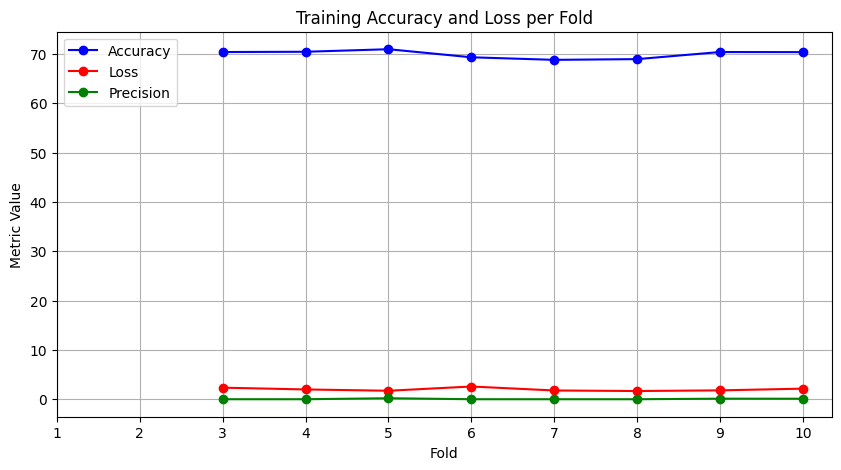

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss per fold in the same figure
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.plot(kfold_list, mean_acc_per_fold, marker='o', linestyle='-', color='b', label='Accuracy')

# Plot loss
plt.plot(kfold_list, mean_loss_per_fold, marker='o', linestyle='-', color='r', label='Loss')

# plot precision
plt.plot(kfold_list, mean_precision_per_fold,marker='o', linestyle='-', color='g', label='Precision')

plt.title('Training Accuracy and Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(range(1, num_folds + 1))
plt.grid(True)
plt.legend()
plt.show()


# Total


In [112]:
import os
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Flatten, Dense
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

# X_train: Features for training
# X_test: Features for testing
# y_train: Labels for training
# y_test: Labels for testing

# Define your data: X_train, y_train, etc.

# Variables to store metrics for each fold

# Hiperparameters
batch_size = 1
no_epochs = 100
verbosity = 1#2  # 1

# Define the K-fold Cross Validator
num_folds = fold_it
kfold = KFold(n_splits=5, shuffle=False)

# K-fold Cross Validation model evaluation for prints
fold_no = 1

# for train, test in kfold.split(X_train, y_train):
# Define the model architecture
model = Sequential()
# Convolutional block 1
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 2
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 3
model.add(BatchNormalization())
model.add(Conv2D(4, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 4
model.add(BatchNormalization())
model.add(Conv2D(4, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))

model.add(Flatten())

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision()])

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            min_delta=0.0001)

# Fit data to model
history = model.fit(X_train_m, y_train_m,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbosity,
                    callbacks=[callback])





------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
907/907 [==============================] - 36s 39ms/step - loss: 2.7139 - accuracy: 0.8743 - precision_6: 0.8138
Epoch 2/100
907/907 [==============================] - 28s 31ms/step - loss: 0.0056 - accuracy: 1.0000 - precision_6: 1.0000
Epoch 3/100
907/907 [==============================] - 27s 30ms/step - loss: 9.5838e-04 - accuracy: 1.0000 - precision_6: 1.0000
Epoch 4/100
907/907 [==============================] - 27s 29ms/step - loss: 3.0250e-04 - accuracy: 1.0000 - precision_6: 1.0000
Epoch 5/100
907/907 [==============================] - 27s 29ms/step - loss: 4.1949e-05 - accuracy: 1.0000 - precision_6: 1.0000
Epoch 6/100
907/907 [==============================] - 26s 29ms/step - loss: 1.0405e-05 - accuracy: 1.0000 - precision_6: 1.0000
Epoch 7/100
907/907 [==============================] - 26s 29ms/step - loss: 4.7774e-06 - accuracy: 1.0000 - precision_6: 1.0000
Epoch 8/

In [113]:
y_test_m


array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0], dtype=int64)

In [114]:
y_pred = model.predict(X_test_m)
y_pred

8/8 [==============================] - 2s 199ms/step


array([[9.99891877e-01],
       [2.54992483e-06],
       [1.14916384e-05],
       [9.96830642e-01],
       [3.60557806e-06],
       [9.99999642e-01],
       [9.99988556e-01],
       [8.42941372e-05],
       [1.43489451e-03],
       [3.87207336e-07],
       [7.16030700e-05],
       [5.68959742e-08],
       [6.76952823e-07],
       [2.59424578e-05],
       [1.42710433e-05],
       [1.29982509e-05],
       [1.95965295e-05],
       [9.99675393e-01],
       [5.47723030e-04],
       [4.35818902e-06],
       [6.73319619e-06],
       [2.18728587e-07],
       [8.75773003e-06],
       [3.01636504e-07],
       [4.60613737e-05],
       [3.16818785e-08],
       [9.99999762e-01],
       [9.67535496e-01],
       [3.42991871e-06],
       [5.40216034e-03],
       [1.09309198e-07],
       [4.98061199e-05],
       [1.34736538e-07],
       [3.60262748e-05],
       [9.99997735e-01],
       [4.89156846e-05],
       [1.95909493e-07],
       [2.94112533e-06],
       [1.21510966e-05],
       [9.70728636e-01],


In [115]:
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)
y_pred_binary

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
    

In [116]:
# Evaluate the model on test data
scores = model.evaluate(X_test_m, y_test_m, verbose=0)
# Generate generalization metrics
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')

# Calculate specificity and F1 Score for the current fold
#for train, test in kfold.split(X_train, y_train):


tn, fp, fn, tp = confusion_matrix(y_test_m, y_pred_binary).ravel()
specificity = tn / (tn + fp)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)




Score for fold 1: loss of 0.0011199887376278639; accuracy of 100.0%


In [117]:

folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/70-20-fold_06_05_2024/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
# Write mean values to the scores.txt file
with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
    file.write(f'Mean Specificity: {specificity}\n')
    file.write(f'Mean Recall: {recall}\n')
    file.write(f'Mean F1 Score: {f1}\n')
    file.write(f'Mean Accuracy: {scores[1] * 100}\n')
    file.write(f'Mean Loss: {scores[0]}\n')
    file.write(f'Mean Precision: {precision}\n')
    file.write(f'True negatives: {tn}\n')
    file.write(f'False negatives: {fn}\n')
    file.write(f'True positives: {tp}\n')
    file.write(f'False positives: {fp}\n')
